In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 5.3 MB/s 
     |████████████████████████████████| 287 kB 40.8 MB/s 


In [ ]:
# mount drive
from google.colab import files
from google.colab import drive

drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/scripts')

Mounted at /content/gdrive


In [ ]:
# import libraries
import pandas as pd
from datetime import date
import numpy as np
import warnings
import time
import CSUtilities as csu
import queries
import matplotlib.pyplot as plt
import io
%matplotlib inline

from google.colab import files

today = date.today()
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
# database connection and credentials
dbname=''
host=''
port=0
user=''
password=''

### Date Range, Groups, and Model

In [ ]:
# date range
date_range = csu.dateRange('2022-06-15', '2022-06-16')
date_range

"createdatutc >= '2022-06-15' and createdatutc <= '2022-06-16 23:59:59'"

In [ ]:
# upload model file
uploaded = files.upload()

Saving model.xlsx to model.xlsx


In [ ]:
# read groups from model file (columns name -> 'groupid')
group_data = pd.read_excel('model.xlsx',sheet_name="groups")
print('duplicate groups:', group_data.duplicated(subset=['groupid']).sum())
groupids = group_data['groupid'].dropna().drop_duplicates()
groupids = tuple(groupids)
print('unique groups:', len(groupids))

duplicate groups: 1
unique groups: 30


In [ ]:
# load model file
model = pd.read_excel(io.BytesIO(uploaded['model.xlsx']),sheet_name='keywords')
model.columns = [x for x in model.iloc[0]]
model = model[1:]
print(model.shape)
model.head()

(121, 5)


,Keywords,Identifier,Main_Subset,Category,Transformations
1,Health,Sub category,Main,Category,"health,sehat, swasth, svasth"
2,Nutrition,Sub category,Main,Category,"nutrition,nutritional,_pusti_,pushti,_পুষ্টি_,..."
3,Diet,Sub category,Main,Category,"_diet_, dieting, kum khaana, kum khana"
4,Nutrients,Sub category,Main,Category,"nutrient, poshak"
5,Vitamin,Sub category,Subset,Category,vitamin


In [ ]:
# make transformations
tx = csu.makeModelTransformations(model)
tx

"TEXTLOWER ILIKE '%health%' OR TEXTLOWER ILIKE '%sehat%' OR TEXTLOWER ILIKE '%swasth%' OR TEXTLOWER ILIKE '%svasth%' OR TEXTLOWER ILIKE '%nutrition%' OR TEXTLOWER ILIKE '%nutritional%' OR TEXTLOWER ILIKE '% pusti %' OR TEXTLOWER ILIKE '%pushti%' OR TEXTLOWER ILIKE '% পুষ্টি %' OR TEXTLOWER ILIKE '%nutritious%' OR TEXTLOWER ILIKE '% diet %' OR TEXTLOWER ILIKE '%dieting%' OR TEXTLOWER ILIKE '%kum khaana%' OR TEXTLOWER ILIKE '%kum khana%' OR TEXTLOWER ILIKE '%nutrient%' OR TEXTLOWER ILIKE '%poshak%' OR TEXTLOWER ILIKE '%chawanprash%' OR TEXTLOWER ILIKE '%chawanpras%' OR TEXTLOWER ILIKE '%chavanprash%' OR TEXTLOWER ILIKE '%chavan prash%' OR TEXTLOWER ILIKE '%chyanwanprash%' OR TEXTLOWER ILIKE '%chyawanpras%' OR TEXTLOWER ILIKE '%chyavanpras%' OR TEXTLOWER ILIKE '% keto %' OR TEXTLOWER ILIKE '%intermittent%' OR TEXTLOWER ILIKE '%intermitent%' OR TEXTLOWER ILIKE '%fasting%' OR TEXTLOWER ILIKE '% vrat %' OR TEXTLOWER ILIKE '%upwaas%' OR TEXTLOWER ILIKE '%upvaas%' OR TEXTLOWER ILIKE '% upwas %

### Query

In [ ]:
tick = time.time()
y = queries.executeQuery(dbname, host, port, user, password, queries.generateSQL('conv', groupids, tx, date_range))
print(f'exec time: {round(time.time()-tick,2)} seconds')
backup = y.copy()

exec time: 18.37 seconds


In [ ]:
# restore y
# y = backup.copy()

### Category Conversations

In [ ]:
catconv, catconv_all, catconv_h, catconv_o, ccftimestamp, ccltimestamp, cc_monthwise, grpbycc = csu.getKPICount(y, group_wise=False, aho='all')
csu.printCount('Cat Conversations', catconv_all, catconv_h, catconv_o, ccftimestamp, ccltimestamp, cc_monthwise, grpbycc)

Cat Conversations: 1215 
Cat Conversations #: 75 
Cat Conversations organic: 1140 
 
First timestamp: 2022-06-15 00:43:05 
Last timestamp: 2022-06-16 23:53:46 

Monthwise Cat Conversations
   Keywords  Jun-22
0    Count    1215


In [ ]:
cc_monthwise

,Keywords,Jun-22
0,Count,1373


In [ ]:
csu.printReferenceConv(catconv, start_index=0, num_conv=5)

In [ ]:
# download dump
# catconv.to_pickle(f'convdump {today}.pickle')
catconv.to_excel(f'convdump {today}.xlsx', index=False)
files.download(f'convdump {today}.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# organic catconv
organic = catconv[~catconv["textlower"].str.contains("#")]
organic.shape

(1299, 7)

In [ ]:
# use organic conversations only
catconv = organic.copy()

### Make convdump1_0

In [ ]:
# create transformations dict
model_dict = csu.makeKeywordDict(model)

In [ ]:
# make 1_0 dump
tick = time.time()
catconv1_0 = csu.makeOneZeroDataFrame(catconv, model_dict)
print(catconv1_0.shape)
print(f'exec time: {round(time.time()-tick,2)} seconds')

(1215, 128)
exec time: 0.88 seconds


In [ ]:
# download 1_0 dump
# catconv.to_pickle(f'convdump1_0 {today}.pickle')
catconv1_0.to_excel(f'convdump1_0 {today}.xlsx', index=False)    # use engine='xlsxwriter' if error is thrown
files.download(f'convdump1_0 {today}.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Mentions & SOV

In [ ]:
# mentions dataframe
keyword_mentions = csu.calculateSOV(model.Keywords.to_list(), catconv1_0)
keyword_mentions.head(10)

,Keywords,Mentions
0,Health,142
1,Nutrition,14
2,Diet,41
3,Nutrients,20
4,Vitamin,15
5,Mineral,6
6,Iron,0
7,Calcium,6
8,Magnesium,1
9,Zinc,0


In [ ]:
# download mentions
keyword_mentions.to_excel('mentions.xlsx', index=False)
files.download('mentions.xlsx')

In [ ]:
# brands sov dataframe
sov = csu.calculateSOV(model[model.Category == 'Brands'].Keywords.to_list(), catconv1_0)
sov.head(3)

,Keywords,Mentions
0,Fisher Price,0
1,Play Doh,0
2,Slurp Farm,1


In [ ]:
# download sov
keyword_mentions.to_excel('sov.xlsx', index=False)
files.download('sov.xlsx')

In [ ]:
# monthwise keyword mentions dataframe
y2 = catconv1_0.copy()
y2.createdatutc = y2.createdatutc.astype('datetime64[M]')
y2 = y2.groupby('createdatutc')[y2.select_dtypes(include='int8').columns].sum().T.astype('int32')
y2.columns = y2.columns.strftime('%b-%y')
y2 = y2.reset_index().rename_axis(None,axis=1).rename(columns={'index':'Keywords'})
y2

,Keywords,Jun-22
0,Fisher Price,0
1,Play Doh,0
2,Slurp Farm,1
3,Medela,0
4,Philips Avent,1
...,...,...
88,Pediatrician,43
89,Maate,0
90,Sanosan,0
91,Spoo,1


In [ ]:
# download mentions monthwise
keyword_mentions.to_excel('mentions monthwise.xlsx', index=False)
files.download('mentions monthwise.xlsx')

In [ ]:
# monthwise brands sov dataframe
y2_brand = y2.merge(model[['Keywords','Category']], on='Keywords',how='left')
y2_brand = y2_brand[y2_brand.Category == 'Brands'].iloc[:,:-1]
y2_brand

,Keywords,Jun-22
0,Fisher Price,0
1,Play Doh,0
2,Slurp Farm,1
3,Medela,0
4,Philips Avent,1
5,Doctor Brown,0
6,Graco,0
7,KidZania,1
8,Zara Kids,0
9,Gap,23


In [ ]:
# download sov monthwise
keyword_mentions.to_excel('sov monthwise.xlsx', index=False)
files.download('sov monthwise.xlsx')

In [ ]:
# Mentions with their category and conversations row dataframe
s2 = model[['Category', 'Keywords']].merge(y2, on='Keywords', how='right')
s2 = pd.concat([cc_monthwise, s2], ignore_index=True)
s2 = s2[list(s2.columns[-1:]) + list(s2.columns[:-1])]
s2.drop_duplicates(inplace=True)
s2.to_clipboard(index=False)
s2.head(5)

,Category,Keywords,May-22,Jun-22
0,NaN,Count,3825,7030
1,Brands,Tata 1mg,334,954
2,Brands,Pharmeasy,0,1
3,Brands,Netmeds,0,0
4,Brands,Apollo Pharmacy,0,0


In [ ]:
# download mentions and conv monthwise
keyword_mentions.to_excel('mentions_and_conv_monthwise.xlsx', index=False)
files.download('mentions_and_conv_monthwise.xlsx')

In [ ]:
# monthwise sov with conversations row dataframe
s2_brand = pd.concat([cc_monthwise, y2_brand])
s2_brand.to_clipboard(index=False)
s2_brand

,Keywords,May-22,Jun-22
0,Count,3825,7030
0,Tata 1mg,334,954
1,Pharmeasy,0,1
2,Netmeds,0,0
3,Apollo Pharmacy,0,0
4,Sasta Sundar,1,0
5,Medplus,0,0
6,Practo,0,0
7,Healthians,0,0
8,Apollo diagnostics,0,0


In [ ]:
# download sov and conv monthwise
keyword_mentions.to_excel('sov_and_conv_monthwise.xlsx', index=False)
files.download('sov_and_conv_monthwise.xlsx')

### Brand Mentions and Conversations

In [ ]:
brand = 'Health'  # name should be same as in model

In [ ]:
m = catconv1_0[catconv1_0[brand] == 1]
mentions, mentions_c, mentions_h, mentions_o, f_ts, l_ts, m_monthwise, grpbymentions = csu.getKPICount(m, group_wise=False, aho='all')
mentions = mentions.loc[:,['groupid','createdatutc','textlower','senti']]

In [ ]:
mentions.head()

,groupid,createdatutc,textlower,senti
3,daf91eb5-b6b2-4414-a150-c9bc74a2fe20,2022-06-15 07:25:02,"#dysonfiltercheck\nthat's great, we can see th...",positive
10,1ba40bb4-7329-453d-a535-20c256a24278,2022-06-15 12:33:21,shivani mishra aditya birla health insurance i...,negative
11,1ba40bb4-7329-453d-a535-20c256a24278,2022-06-15 13:14:58,manjeet kaur tata 1mg is areliable lab. as a ...,positive
12,6df3f44f-d87a-48e8-8bcf-710aa06b56bf,2022-06-15 01:08:55,yes dear baby ke growth ke liye proper nutrien...,positive
13,3897d416-0bea-4bf9-85ee-2d90da6563a6,2022-06-15 01:45:00,i suggest you get more information from my htt...,positive


In [ ]:
# mentions
csu.printCount('mentions', mentions_c, mentions_h, mentions_o, f_ts, l_ts, m_monthwise, grpbymentions)

mentions: 142 
mentions #: 58 
mentions organic: 84 
 
First timestamp: 2022-06-15 00:43:05 
Last timestamp: 2022-06-16 23:53:46 

Monthwise mentions
   Keywords  Jun-22
0    Count     142


In [ ]:
m_monthwise

,Keywords,May-22,Jun-22
0,Count,2256,2432


In [ ]:
# Posts having brand mentions
post_ids = set(m[m.type == 'Post'].sourceid)
len(post_ids)

36

In [ ]:
# brand conversations (posts having brand mentions along with all the comments (may or may not have brand mentions) + separate comments with brand mentions)
bc = pd.concat([m, catconv[catconv.parentsourceid.isin(post_ids)]], ignore_index=True).drop_duplicates(subset=['sourceid'])
brandconv, bc_c, bc_h, bc_o, ftimestamp, ltimestamp, bc_monthwise, grpbybc = csu.getKPICount(bc, group_wise=False, aho='all')
brandconv = brandconv.loc[:,['groupid','createdatutc','textlower']]

In [ ]:
csu.printCount('conversations', bc_c, bc_h, bc_o, ftimestamp, ltimestamp, bc_monthwise, grpbybc)

conversations:                                       66 
conversations #:                                      0 
conversations organic:                               66 
First timestamp:                    2022-06-15 00:21:48 
Last timestamp:                     2022-06-16 19:38:06 

Month wise conversations:     
   Keywords  Jun-22
0    Count      66


In [ ]:
bc_monthwise

,Keywords,May-22,Jun-22
0,Count,7090,7838


In [ ]:
csu.printReferenceConv(df=mentions, start_index=0, num_conv=1)

                                                Reference Conversations                                                 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
#Tata1mg #1mg #1mgforevery1 #BringingCareToHealth #RightDiagnosticForAll
This is really very useful and helps to know our health very easily and that by sitting at home
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
# download mentions
mentions.to_excel(f'mentions {today}.xlsx', index=False)
files.download(f'mentions {today}.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
mentions_upload = files.upload()

Saving mentions 2022-06-24.xlsx to mentions 2022-06-24 (1).xlsx


In [ ]:
# upload updated mentions
mentions = pd.read_excel(io.BytesIO(mentions_upload[f'mentions {today}.xlsx']))
mentions.shape

(59, 4)

In [ ]:
# sentiments
csu.calculateSentiments(mentions, month_wise=False)

,senti,Count
0,positive,58
1,neutral,1
2,negative,0


In [ ]:
# download brand conversations
brandconv.to_excel(f'brandconv {today}.xlsx', index=False)
files.download(f'brandconv {today}.xlsx')

In [ ]:
# upload stopwords
stopword_upload = files.upload()
stopwords = pd.read_csv(io.BytesIO(stopword_upload['stop-word-list.csv']), header=None)
stopwords = set(stopwords.iloc[:,0].astype('str').tolist())

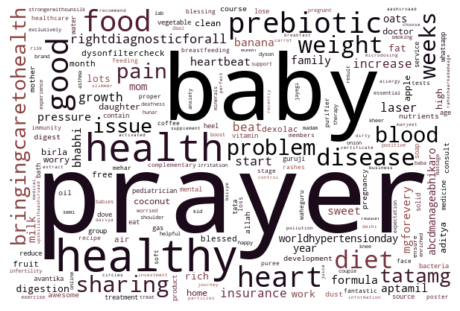

In [ ]:
# wordcloud
wc_text = csu.preprocess(' '.join(brandconv.textlower.values))
wc_image = csu.generateWordCloud(wc_text, stopwords=stopwords)
fig = plt.figure(figsize=(8,6))
plt.imshow(wc_image, interpolation='bilinear')
plt.axis('off')
plt.show()

### Brand Attributes

In [ ]:
# read attributes sheet in model file
# first row should contain header (columns - Keywords, Main_Subset, Transformations). All attributes must be main
# transformations can be given in transformation columns or simply copy paste the keywords column (do fix keywords, e.g. try/tried -> try, tried)
attributes = pd.read_excel(io.BytesIO(uploaded['model.xlsx']),sheet_name='attributes')
print(attributes.shape)
attributes.head(3)

(28, 3)


,Keywords,Main_Subset,Transformations
0,buy,Main,"buy, bought"
1,try,Main,"try, tried"
2,use,Main,"_use_,using, used"


In [ ]:
# attributes dictionary and attributes 1_0 dump
att_dict = csu.makeKeywordDict(attributes)
tick = time.time()
bc_for_attr = csu.makeOneZeroDataFrame(brandconv, att_dict)
print(f'exec time: {round(time.time()-tick,2)} seconds')

exec time: 0.05 seconds


In [ ]:
# print brand attributes count
brandattr = np.sum(bc_for_attr[attributes.Keywords.tolist()], axis=0)
brandattr = pd.DataFrame(brandattr, columns=['Count']).reset_index()
brandattr

,index,Count
0,buy,2
1,try,17
2,use,33
3,recommend,20
4,Daily Moisture,2
5,Soothing Relief,4
6,Dermexa,0
7,Wash,11
8,Lotion,20
9,Cream,1


In [ ]:
brandattr.to_excel('brandattributes.xlsx', index=False)
files.download('brandattributes.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>